In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Řešení Poissonovy rovnice

Vypočtěte teplotní profil uvnitř polystyrenové desky s tepelnou vodivostí $k=0.03\rm\ W / m\,K$ o síle $L=0.1\rm\ m$, kde na jedné straně desky je teplota $T_1 = 200\rm\ K$ a na druhé straně $T_2 = 300\rm\ K$.

Řešte tedy Laplaceovu rovnici
$$\Delta T = 0$$
(Obecněji $\nabla\cdot(k\nabla T)=0$) Použijte 100 mřížových bodů (včetně okrajů). Řešte nejprve Jacobiho metodou. Jako kritérium zastavení výpočtu porovnávejte sumu kvadrátů změny v poslední iteraci s epsilon=1e-5: `sum(res**2) < epsilon**2`

In [14]:
xmax = 0.1
k = 0.03
T1, T2 = 200., 300.
epsilon=1e-5

In [15]:
Nx = 100
dx = xmax/(Nx-1)

Definujeme pole neznámých a zapíšeme okrajové podmínky

In [16]:
U0 = np.zeros(Nx)
U0[0] = T1
U0[-1] = T2

In [17]:
def solve_poisson_jac(U0, maxiter=100000, epsilon=1e-5):
    """Solve Poisson equation with Dirichlet BC by the Jacobi method"""
    U = U0.copy()
    for it in range(maxiter):
        res = 0.5*(U[:-2] + U[2:]) - U[1:-1]
        U[1:-1] += res
        if sum(res**2) < epsilon**2: break
    return U, it

In [18]:
U, it = solve_poisson_jac(U0, epsilon=1e-5)
print(it)

23140


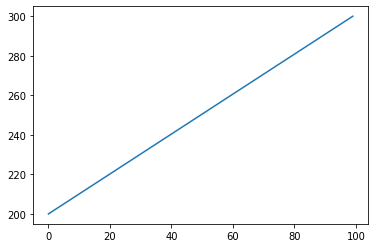

In [11]:
plt.plot(U)

Přidejte vyhřívání $S=10^5\rm W\cdot m^{-3}$. $\Delta T = -S/k$

In [32]:
def solve_poisson_jac_RHS(U0, RHS, h, maxiter=100000, epsilon=1e-5):
    """Solve Poisson equation with Dirichlet BC by the Jacobi method"""
    U = U0.copy()
    for it in range(maxiter):
        res = 0.5*(U[:-2] + U[2:]) + h**2*RHS/2 - U[1:-1]
        U[1:-1] += res
        if sum(res**2) < epsilon**2: break
    return U, it

In [33]:
U, it = solve_poisson_jac_RHS(U0, 100000, dx, epsilon=1e-5)


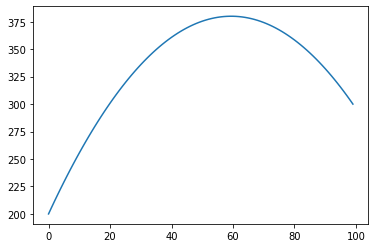

In [34]:
plt.plot(U)

Řešte stejný problém Gauss-Seidelovou metodou a porovnejte potřebný počet iterací

In [12]:
def solve_poisson_gs(U0, Nx, maxiter=100000):
    """Solve Poisson equation with Dirichlet BC by the Gauss-Seidel method"""
    U = U0.copy()
    for it in range(maxiter):
        err=0
        for i in range(1,Nx-1):
            res = 0.5*(U[i-1] + U[i+1]) - U[i]
            U[i] += res
            err += res**2
        if err < epsilon**2: break
    return U, it

In [13]:
U, it = solve_poisson_gs(U0, Nx)
print(it)

12244


#### Poznámka: vektorizované operace vs for cykly v Pythonu
G-S metodou nám tedy stačí poloviční počet iterací. Je také dvakrát rychlejší?

In [314]:
%timeit solve_poisson_jac(U0)
%timeit solve_poisson_gs(U0)

505 ms ± 8.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.69 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Není, protože Gauss-Seidelovu metodu s "přirozeným" pořadím prvků nelze jednoduše zapsat s pomocí vektorizovaných operací v Pythonu. Cykly v pythonu jsou pomalé oproti numpy vektorizovaným operacím:

In [256]:
%timeit res = 0.5*(U[:-2] + U[2:]) - U[1:-1]

2.39 µs ± 105 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [315]:
%%timeit
res = np.zeros(Nx-1)
for i in range(1, Nx-1): res[i-1] = 0.5*(U[i-1] + U[i+1]) - U[i]

75 µs ± 2.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Později si ukážeme, jak tento problém vyřešit s pomocí red-black orderingu...

Aplikujte superrelaxaci v řešiči s Gauss-Seidelovou metodou. Studujte závislost počtu iterací na parametru `omega` v intervalu `[1, 2]`.

In [316]:
def solve_poisson_SOR(U0, Nx, omega, maxiter=10**5):
    U = U0.copy()
    for it in range(maxiter):
        err=0
        for i in range(1,Nx-1):
            res = 0.5*(U[i-1] + U[i+1]) - U[i]
            U[i] += res*omega
            err += res**2
        if err < epsilon**2: break
    return U, it

In [317]:
omega = np.linspace(1, 2, 100)
iters = [solve_poisson_SOR(U0, Nx, o)[1] for o in omega]

Teoretická hodnota optimálního parametru $\omega$ je (bez důkazu):

In [318]:
rho_jac = np.cos(np.pi/(Nx-2))
rho_gs = rho_jac**2
omega_theory = 2/(1+np.sqrt(1 - rho_gs))

(0.0, 13000.0)

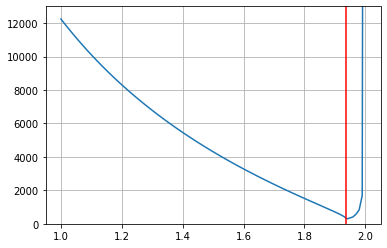

In [301]:
plt.plot(omega, iters)
plt.axvline(omega_theory, c="r")
plt.grid()
plt.ylim(0, 13000)

Vektorizace SOR v pythonu: red black ordering (oddělená iterace sudých a lichých bodů v 1D)

In [240]:
def solve_poisson_SOR_red_black(U0, Nx, omega, maxiter=10**2):
    U = U0.copy()
    odd = np.arange(1,Nx-2,2)
    even = np.arange(2,Nx-1,2)
    res = np.zeros(Nx)
    for it in range(maxiter):
        for ii in (odd, even):
            res[ii] = 0.5*(U[ii-1] + U[ii+1]) - U[ii]
            U[ii] += res[ii]*omega

        if sum(res**2) < epsilon**2: break
    return U, it

Nyní si opět porovnejme rychlost našich metod:

In [321]:
%timeit solve_poisson_jac(U0)
%timeit solve_poisson_gs(U0, Nx)
%timeit solve_poisson_SOR(U0, Nx, omega_theory)
%timeit solve_poisson_SOR_red_black(U0, Nx, omega_theory)

498 ms ± 7.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.76 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
47.3 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.59 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Neumannovy okrajové podmínky
Chceme zavést podmínku $U_0' = \rm const$. Jednoduchou možností je přidat rovnici
$$\frac{U_1 - U_0}{\Delta x} = U_0',$$
ale ta je pouze prvního řádu přesnosti (dopředné diference). Možným řešením je přidání fiktivního bodu $U_{-1}$ mimo pracovní oblast, čímž dostaneme aproximaci druhého řádu přesnosti:
$$\frac{U_1 - U_{-1}}{2\Delta x} = U_0'.$$
Fiktivní bod můžeme vyjádřit jako $U_{-1} = U_1 - 2\Delta x U_0'$ a eliminovat kombinací s Poissonovou rovnicí pro nultý bod:
$$-k\frac{U_{-1} - 2U_0 + U_1}{\Delta x^2} = 0,$$
čímž dostaneme rovnici
$$-k\frac{2U_{1} - 2U_0}{\Delta x^2} = -\frac{2kU_0'}{\Delta x},$$
$${U_{1} - U_0} = U_0'\Delta x.$$



Spočtěme nyní, jaká bude teplota na povrchu již studované polystyrenové desky, pokud na jednom jejím povrchu bude ve vakuu deponován výkon $100\ \rm W/m = kT_0'$ (například vlivem slunečního záření), zatímco na druhé straně bude fixní teplota $273\ \rm K$.

In [164]:
J0 = 100. # W m^-2
dT0 = -J0/k
T1 = 273. # K

In [165]:
def solve_poisson_neumann(Nx, dx, omega, dT0, T1, maxiter=10**5):
    U = np.zeros(Nx)
    U[-1] = T1
    for it in range(maxiter):
        err=0
        
        for i in range(0,Nx-1):
            if i==0:
                res = U[1] - dT0*dx - U[0]
            else:
                res = 0.5*(U[i-1] + U[i+1]) - U[i]
            U[i] += res*omega
            err += res**2
        if err < epsilon**2: break
    return U, it

In [167]:
T, it = solve_poisson_neumann(Nx, dx, omega_theory, dT0, T1)

In [173]:
k*(T[0]-T[-1])/xmax

99.99989150816087

### Poissonova rovnice ve 2D

Ukázka první: Poissonova rovnice pro "polystyrenový hranol" se čtvercovým průřezem o hraně $0.1\ \rm m$. Teploty na jednotlivých stěnách hranolu jsou 100, 200, 300 a 400 K (po směru hod. ručiček).

In [338]:
xmax = 0.1
ymax = 0.1
k = 0.03
Tl, Tr = 100., 300. # left right
Tt, Tb = 200., 400. # top bottom
Nx, Ny = 100, 100
dx, dy = xmax/(Nx-1), ymax/(Ny-1)

In [324]:
rho_jac_2D = (np.cos(np.pi/(Nx-2)) + (dx/dy)**2 * np.cos(np.pi/(Ny-2))) / (1 + (dx/dy)**2)
rho_gs_2D = rho_jac_2D**2
omega_theory_2D = 2/(1+np.sqrt(1 - rho_gs_2D))

In [325]:
omega_theory_2D

1.9378876438577415

In [347]:
def solve_poisson_2D(xmax, ymax, Nx, Ny, omega, bc=[1, 1, 1, 1], maxiter=10**5, epsilon=1e-5):
    U = np.zeros((Nx, Ny))
    
    # zapisme okr. podmiky na okraje pole
    U[:,0] = bc[0]
    U[0,:] = bc[1]
    U[:,-1] = bc[2]
    U[-1,:] = bc[3]
    for it in range(maxiter):
        err=0
        for i in range(1, Ny-1):
            for j in range(1, Nx-1):
                res = 0.25*(U[i-1,j] + U[i+1,j] + U[i,j-1] + U[i,j+1]) - U[i,j]
                U[i, j] += res*omega
                err += res**2
        if err < epsilon**2: break
    return U, it

In [272]:
def solve_poisson_2D_red_black(xmax, ymax, Nx, Ny, omega, bc=[1, 1, 1, 1], maxiter=10**5, epsilon=1e-5):
    U = np.zeros((Nx, Ny))
    
    # assign boundary conditions on the edges
    U[:,0] = bc[0]
    U[0,:] = bc[1]
    U[:,-1] = bc[2]
    U[-1,:] = bc[3]
    
    # define checkerboard pattern within the working area
    red = np.zeros((Nx, Ny), dtype=bool)
    red[1:-1:2, 1:-1:2] = True
    red[2:-1:2, 2:-1:2] = True
    black = np.zeros((Nx, Ny), dtype=bool)
    black[1:-1, 1:-1] = ~red[1:-1, 1:-1]
    
    # and get indices of red and black points
    red = np.nonzero(red)
    black = np.nonzero(black)
    
    res = np.zeros((Nx, Ny))
    for it in range(maxiter):
        for i, j in (red, black):
            res[i,j] = 0.25*(U[i-1,j] + U[i+1,j] + U[i,j-1] + U[i,j+1]) - U[i,j]
            U[i,j] += res[i,j]*omega
        if np.sum(res**2) < epsilon**2: break
    return U, it

In [339]:
U, it = solve_poisson_2D_red_black(xmax, ymax, Nx, Ny, omega_theory_2D, bc=[Tl, Tt, Tr, Tb], maxiter=100000)

In [348]:
%timeit solve_poisson_2D(xmax, ymax, Nx, Ny, omega=omega_theory_2D, bc=[Tl, Tt, Tr, Tb])
%timeit solve_poisson_2D_red_black(xmax, ymax, Nx, Ny, omega_theory_2D, bc=[Tl, Tt, Tr, Tb], maxiter=100000)

7.36 s ± 77.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
156 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


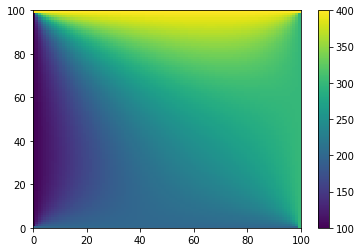

In [340]:
plt.pcolormesh(U)
plt.colorbar()

https://my.ece.utah.edu/~ece6340/LECTURES/Feb1/Nagel%202012%20-%20Solving%20the%20Generalized%20Poisson%20Equation%20using%20FDM.pdf